In [2]:
from utils import *
from models import *
from data import *

import torch
import numpy as np

from tqdm.notebook import tqdm


# auto reload
%load_ext autoreload
%autoreload 2

Using LASA DataSet from /home/agokhale/.local/lib/python3.11/site-packages/pyLasaDataset/resources/LASAHandwritingDataset/DataSet


# Display LASA Trajectories

LASA Dataset

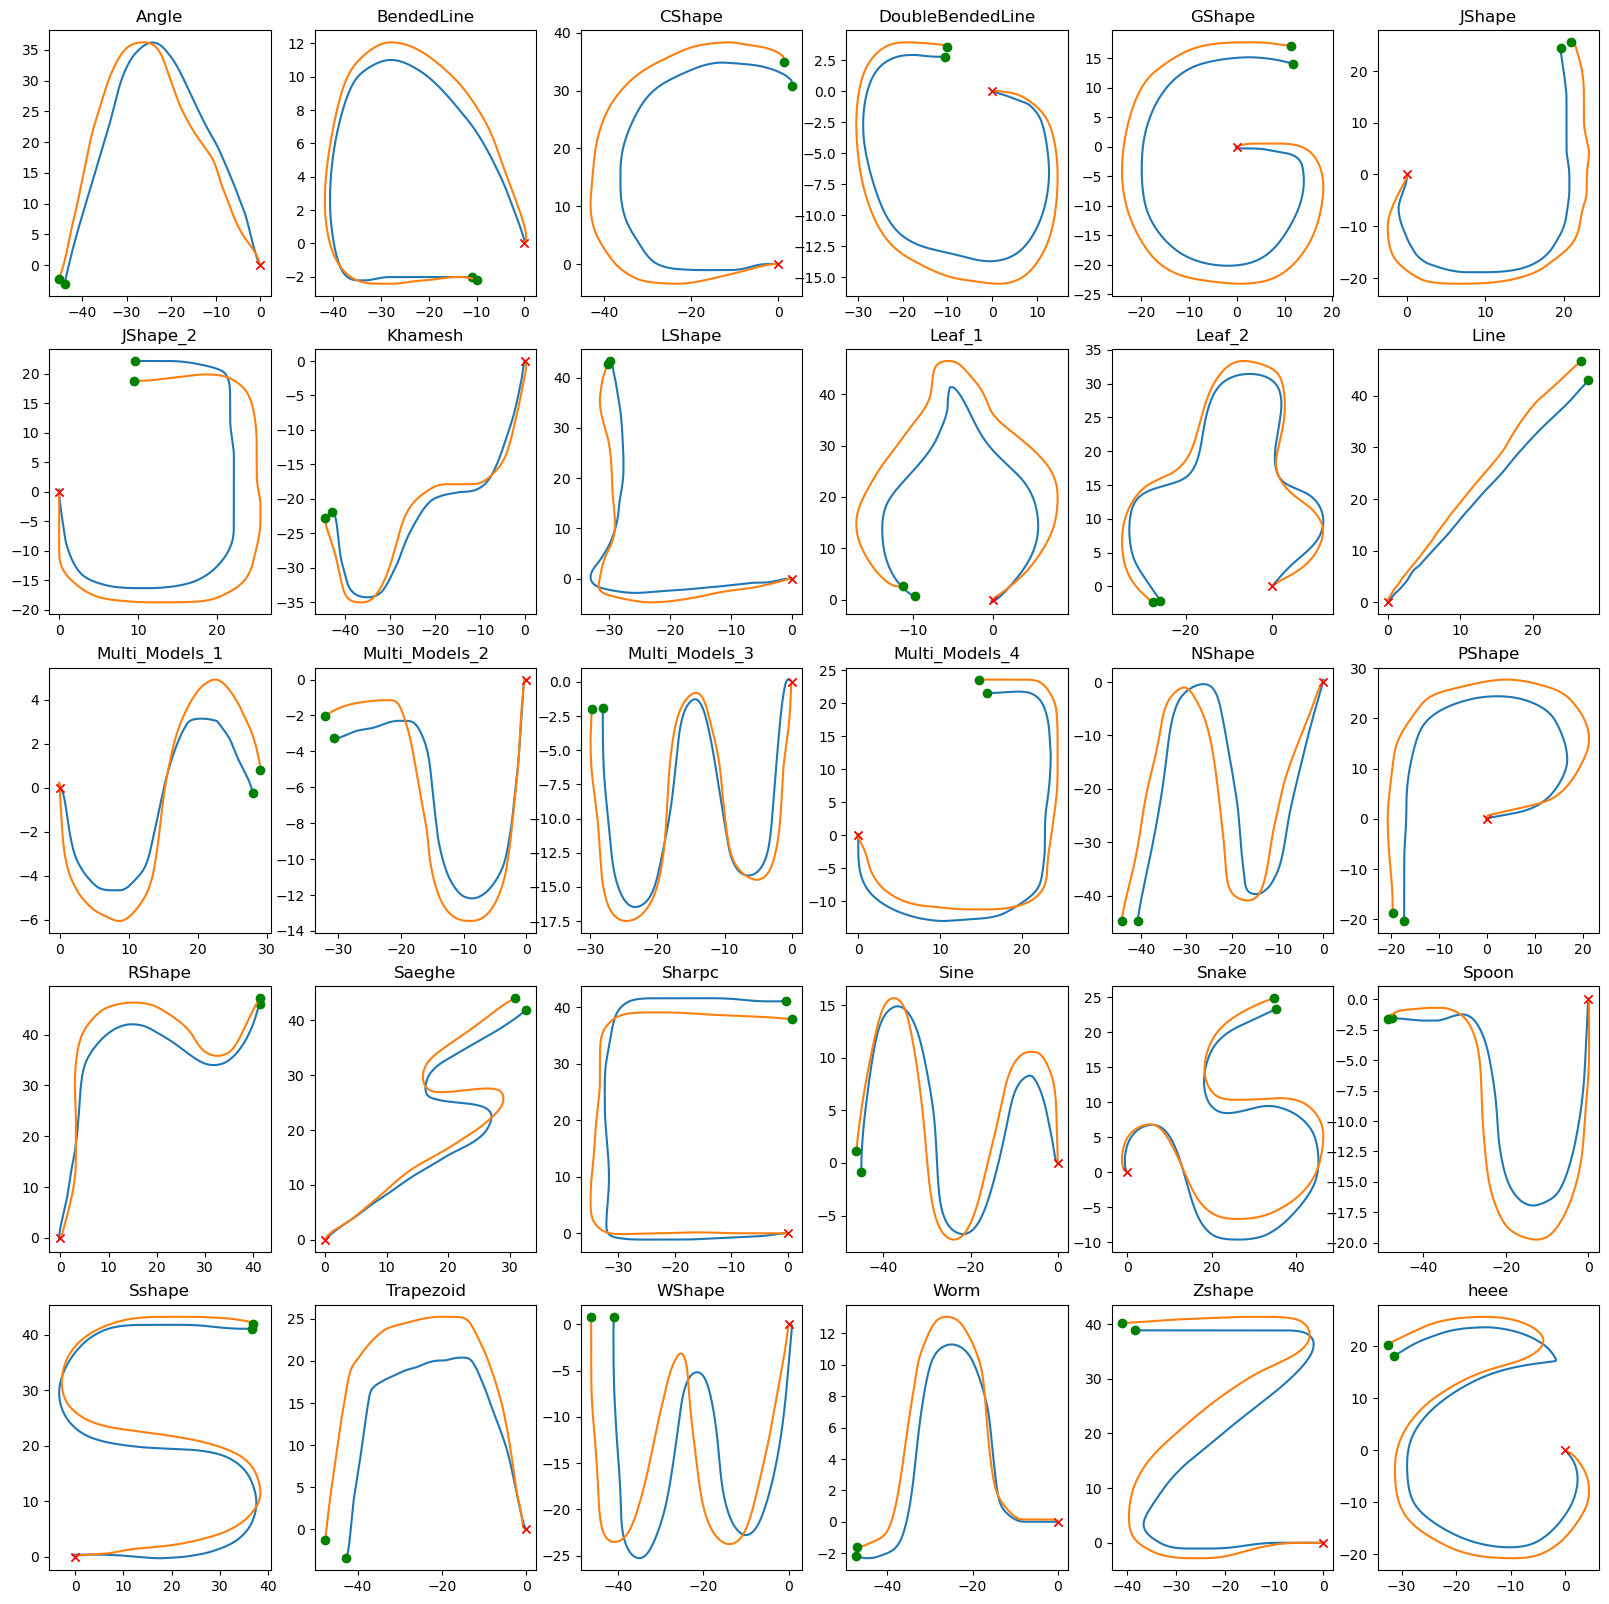

In [3]:
# make a 5 x 6 grid of every lasa dataset plot
fig, axs = plt.subplots(5, 6, figsize=(20, 20))
for i, name in enumerate(data_set_names):
    pos, vel = lasa_to_torch(name)
    # plot pos
    axs[i // 6, i % 6].set_title(name)
    for j in range(pos.shape[1]):
        axs[i // 6, i % 6].plot(pos[j,0], pos[j,1], label=name)
        
        # put a small x at the end
        axs[i // 6, i % 6].plot(pos[j,0, 0], pos[j,1, 0], 'o', color='green')
        axs[i // 6, i % 6].plot(pos[j,0, -1], pos[j,1, -1], 'x', color = 'red')
plt.show()

# Train on a 2D Curve

In [4]:
def train(model, loader, lr = 1e-3, epochs = 10, device = 'cpu'):
    
    def cuda(x):
        return x.to(device)
    losses = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model = cuda(model)
    criterion = torch.nn.MSELoss()

    prog = tqdm(range(1, epochs + 1))
    for epoch in prog:
        total_loss = 0
        for x, y in loader:
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        prog.set_description(f"Loss: {total_loss}")
        losses.append(total_loss)


Load Trajectory Data

In [5]:
from data import *
dataset_names = [ "Sshape"]
data_config = {
    "class": "LASA",
    "num_demos": 3,
    "label": dataset_names,
    "batch_size": 100,
}
loader, data_dim, x_eq = load_data_from_config_new(data_config)


Initiate Model and optimizer

In [6]:
model_config = {
    "type": "ELCD",
    "flow_steps": 2,
    "latent_dim": data_dim,
    "hidden_dim": 16,
}
model = get_model_from_config(model_config, data_dim=data_dim, x_eq=x_eq)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

/home/agokhale/Sean/Extended-Linearized-Contracting-Dynamics/models/elcd.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x_eq = torch.tensor(x_eq)


Eq point: tensor([[0., 0.]])


Train

In [7]:
train(model, loader, lr=1e-3, epochs=100, device = 'cpu')

  0%|          | 0/100 [00:00<?, ?it/s]

/home/agokhale/Sean/Extended-Linearized-Contracting-Dynamics/manifold_flow/transforms/lu.py:89: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2192.)
  outputs, _ = torch.triangular_solve(outputs.t(), lower, upper=False, unitriangular=True)


## Visualize Result

Select which trajector of curve to visualize.

In [9]:
traj_idx = 0

Get unshuffled data for visualization

In [10]:
traj_x  = loader.dataset.pos[traj_idx].transpose(1,0)
traj_x_dot = loader.dataset.vel[traj_idx].transpose(1,0)

Visaulize data

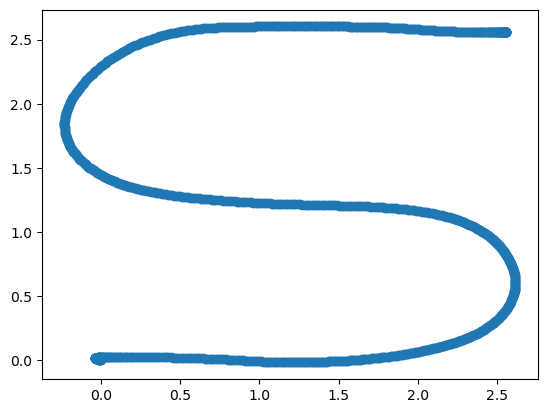

In [11]:
s = 0 # tODO delete for 2d trajectory
plt.scatter([x[2 * s] for x in traj_x], [x[1 + 2*s] for x in traj_x])

Get model's prediction for velocity at every point in data trajectory

In [12]:
x_pred = model(traj_x).detach().numpy()

Generate new trajectory form model starting at data trajectory initial point.

In [13]:
f = lambda x, dt: single_ode45_step(model,x, dt)
x0 = loader.dataset.pos[traj_idx,:,0].unsqueeze(0)

Y = forward_step_until_converge(f=f, x0=x0, dt = 0.01).detach().numpy()

Plot results.

Blue arrows are model's prediction of velocity along data trajectory. Black arrows are model's prediction of velocity at grid points. Vidris line is path taken by trajectory produced by model.

ValueError: Dimension 1 in inputs must be of size 4.

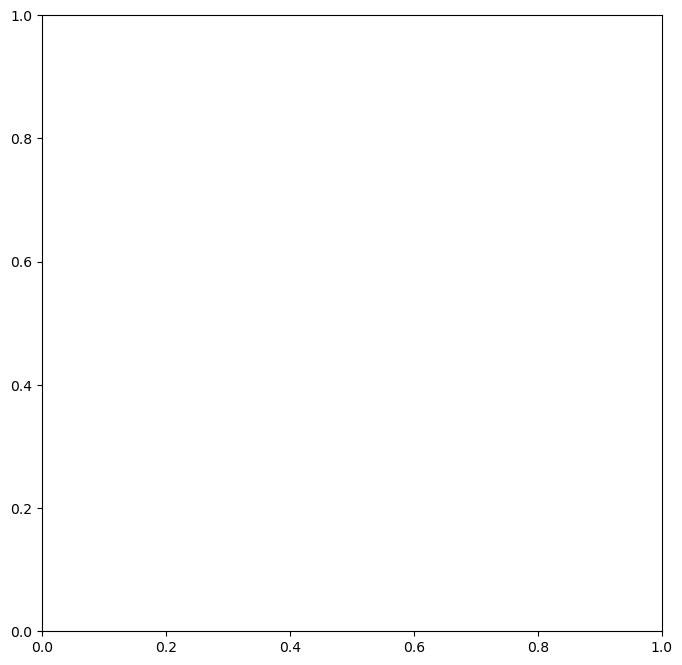

In [18]:
x_c, y_c = 1.5,1.5 # center of plot
n = 2 # length and width of plot

ax = plot_2d_vector_field(model, x_c -n, x_c + n, y_c - n, y_c + n)

every_other = 10
s =0 # which shape to draw

 # which shape to draw
ax.quiver([x[2 * s] for x in traj_x[::every_other]],
            [x[ 1 +  (2 * s)]  for x in traj_x[::every_other]], 
          [x[2 * s] for x in x_pred][::every_other], 
          [x[1 + (2 * s)]  for x in x_pred][::every_other], 
          color='blue')


plt.plot(Y[:,0,s * 2], Y[:,0,1  +(2 * s)], 'r')


plt.show()


# Train on a 4d Curve

Load Trajecotry data, which is two, 2-d curves stacked on top of eachother.

In [15]:
from data import *
dataset_names = [ "PShape", "NShape"]
data_config = {
    "class": "LASA",
    "num_demos": 3,
    "label": dataset_names,
    "batch_size": 100,
}
loader, data_dim, x_eq = load_data_from_config_new(data_config)

Load model and optimizer

In [16]:
model_config = {
    "type": "ELCD",
    "flow_steps": 2,
    "latent_dim": data_dim,
    "hidden_dim": 16,
}
model = get_model_from_config(model_config, data_dim=data_dim, x_eq=x_eq)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Eq point: tensor([[0., 0., 0., 0.]])


/home/agokhale/Sean/Extended-Linearized-Contracting-Dynamics/models/elcd.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x_eq = torch.tensor(x_eq)


In [17]:
train(model, loader, lr=1e-3, epochs=100, device = 'cpu')

  0%|          | 0/100 [00:00<?, ?it/s]

## Visualize Result

Select which trajectory or 4-d curve to visualize

In [19]:
traj_idx = 0

Get unshuffled data for visualization

In [20]:
traj_x  = loader.dataset.pos[traj_idx].transpose(1,0)
traj_x_dot = loader.dataset.vel[traj_idx].transpose(1,0)

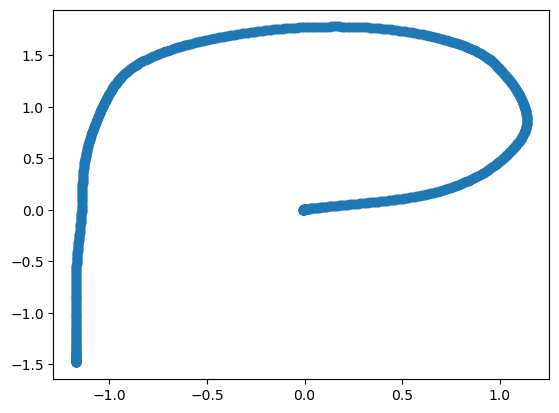

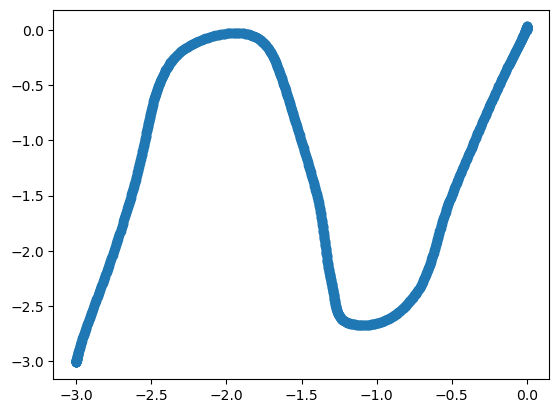

In [21]:
for s in range(2):
    plt.scatter([x[2 * s] for x in traj_x], [x[1 + 2*s] for x in traj_x])
    plt.show()


Get model's prediction for velocity at every point along data trajectory.

In [22]:
x_pred = model(traj_x).detach().numpy()

Generate new trajectory form model starting at data trajectory initial point.

In [23]:
f = lambda x, dt: single_ode45_step(model,x, dt)
x0 = loader.dataset.pos[traj_idx,:,0].unsqueeze(0)

Y = forward_step_until_converge(f=f, x0=x0, dt = 0.01).detach().numpy()

Plot results.

Blue arrows are model's prediction of velocity along data trajectory. Black arrows are model's prediction of velocity at grid points. Vidris line is path taken by trajectory produced by model.

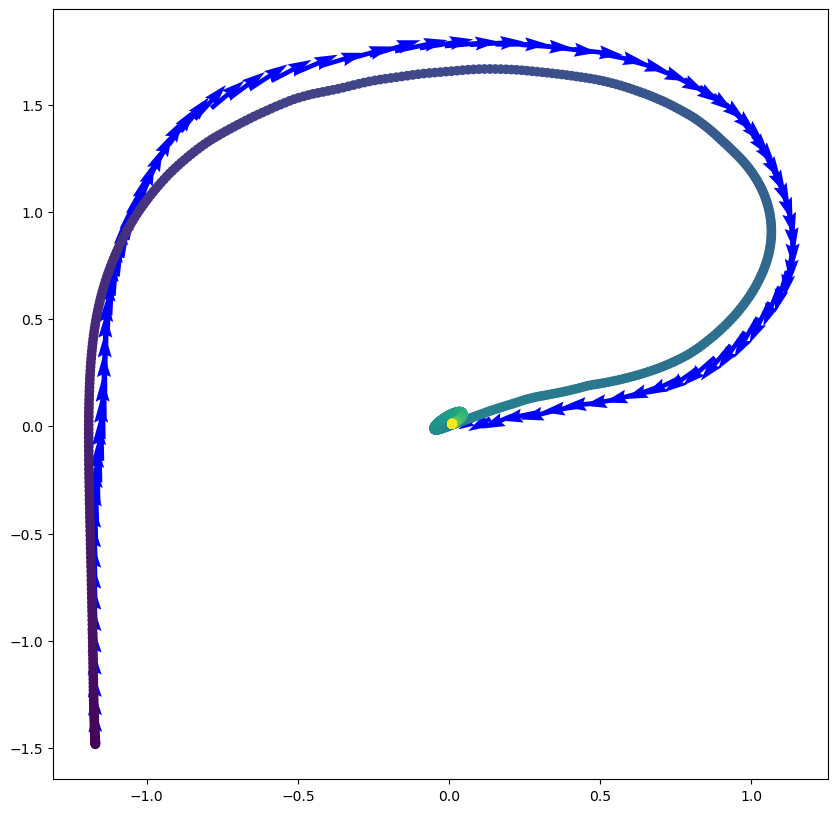

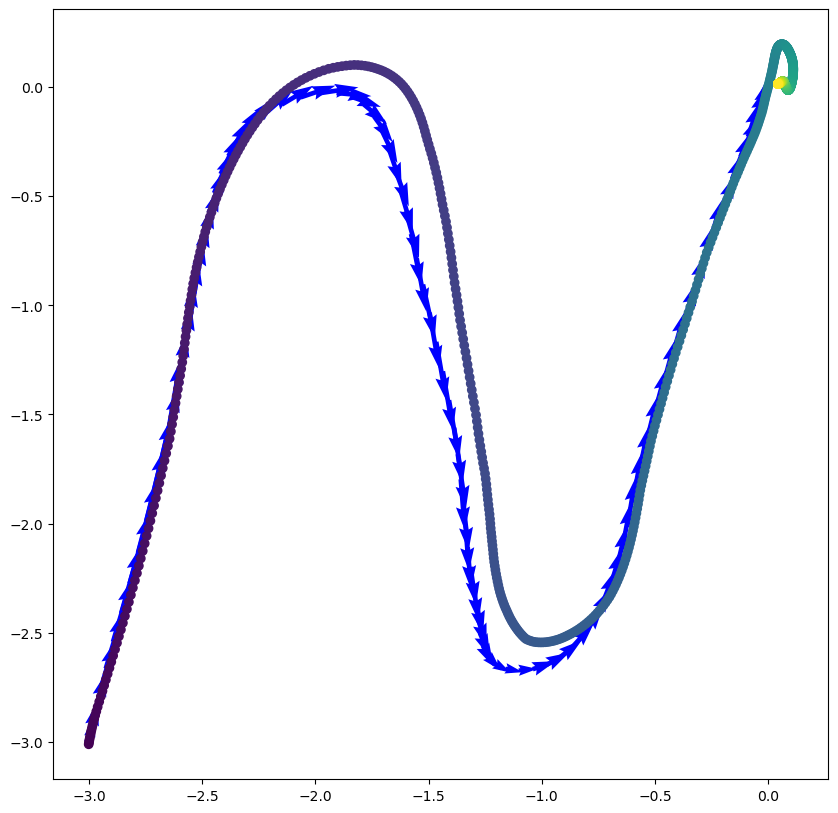

In [24]:

for s in range(data_dim // 2):

  f, ax = plt.subplots(1,1, figsize=(10,10)) 
  every_other = 10 # plot predictions along every 10th point of data trajectory

  ax.quiver([x[2 * s] for x in traj_x[::every_other]],
              [x[ 1 +  (2 * s)]  for x in traj_x[::every_other]], 
            [x[2 * s] for x in x_pred][::every_other], 
            [x[1 + (2 * s)]  for x in x_pred][::every_other], 
            color='blue')


  plt.scatter(Y[:,0,s * 2], Y[:,0,1  +(2 * s)], cmap='viridis', c=np.arange(len(Y[:,0,0])))


  plt.show()